In [1]:
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available!")
    
    # Number of GPUs available
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"\nDetails for GPU {i}:")
        print(f"Name: {torch.cuda.get_device_name(i)}")
        print(f"Total Memory: {torch.cuda.get_device_properties(i).total_memory / (1024**3):.2f} GB")
        print(f"Multi-Processor Count: {torch.cuda.get_device_properties(i).multi_processor_count}")
        print(f"Compute Capability: {torch.cuda.get_device_capability(i)}")
else:
    print("CUDA is not available on this system.")

CUDA is available!
Number of GPUs available: 1

Details for GPU 0:
Name: NVIDIA A100-SXM4-80GB
Total Memory: 79.14 GB
Multi-Processor Count: 108
Compute Capability: (8, 0)


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SwinModel
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm

In [3]:
# Load your data
data = np.load('2023-11-15-cine-myo-masks-and-TOS.npy', allow_pickle=True)

In [4]:
print(len(data))

128


In [5]:
# dropping all data with 20 frames
data = np.array([i for i in data if i['cine_lv_myo_masks_cropped'].shape[2] != 20])

In [6]:
print(len(data))

113


In [7]:
# dropping all data with variance below 10
data = np.array([i for i in data if np.var(i['TOS']) > 10])

In [8]:
print(len(data))

110


In [18]:
# Custom Dataset Class
class MyDataset(Dataset):
    def __init__(self, data, desired_num_frames=32):
        self.inputs = []
        self.targets = []
        self.desired_num_frames = desired_num_frames
        for item in data:
            mask_volume = item['cine_lv_myo_masks_cropped']  # Shape: (H, W, n_frames)
            tos = item['TOS']  # Shape: (126,)
            self.inputs.append(mask_volume)
            self.targets.append(tos)
            
        self.resize = transforms.Resize((224, 224))
        self.to_tensor = transforms.ToTensor()
        self.to_pil = transforms.ToPILImage()
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        mask_volume = self.inputs[idx]  # Shape: (H, W, n_frames)
        tos = self.targets[idx]  # Shape: (126,)
        
        # Rearrange mask_volume to (n_frames, H, W)
        mask_volume = mask_volume.transpose(2, 0, 1)  # Now shape is (n_frames, H, W)
        
        # Ensure the number of frames is desired_num_frames
        num_frames = mask_volume.shape[0]
        desired_num_frames = self.desired_num_frames
        # if num_frames < desired_num_frames:
        #     # Pad with zeros (blank frames)
        #     pad_size = desired_num_frames - num_frames
        #     pad_frames = np.zeros((pad_size, mask_volume.shape[1], mask_volume.shape[2]))
        #     mask_volume = np.concatenate((mask_volume, pad_frames), axis=0)
        # elif num_frames > desired_num_frames:
        #     # Sample frames evenly
        #     indices = np.linspace(0, num_frames - 1, desired_num_frames, dtype=int)
        #     mask_volume = mask_volume[indices]
        # Now mask_volume has shape (desired_num_frames, H, W)
        
        # Process each frame
        frames = []
        for frame in mask_volume:
            frame = frame.astype(np.uint8)  # Convert to uint8
            frame_pil = self.to_pil(frame)
            frame_resized = self.resize(frame_pil)
            frame_tensor = self.to_tensor(frame_resized)
            # Repeat the grayscale channel to make it 3 channels
            frame_tensor = frame_tensor.repeat(3, 1, 1)
            frames.append(frame_tensor)
        
        # Stack frames to create a tensor of shape (desired_num_frames, 3, 224, 224)
        frames_tensor = torch.stack(frames)  # Shape: (desired_num_frames, 3, 224, 224)
        
        # Convert tos to tensor
        tos_tensor = torch.tensor(tos, dtype=torch.float32)
        
        return frames_tensor, tos_tensor

In [19]:
# Split dataset into training and evaluation sets
dataset = MyDataset(data, desired_num_frames=25)
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=4, shuffle=False)


In [20]:
# Define the Regression Model
class SwinRegressionModel(nn.Module):
    def __init__(self):
        super(SwinRegressionModel, self).__init__()
        self.swin = SwinModel.from_pretrained('microsoft/swin-base-patch4-window7-224')
        self.config = self.swin.config
        self.fc = nn.Linear(self.config.hidden_size, 126)
        
    def forward(self, x):
        # x: (batch_size, desired_num_frames, 3, 224, 224)
        batch_size, n_frames, C, H, W = x.size()
        x = x.view(batch_size * n_frames, C, H, W)  # Merge batch and frames
        outputs = self.swin(x)
        # outputs.last_hidden_state: (batch_size * n_frames, num_patches, hidden_size)
        # Pool over spatial dimensions (mean pooling)
        hidden_states = outputs.last_hidden_state.mean(dim=1)  # (batch_size * n_frames, hidden_size)
        # Reshape back to (batch_size, n_frames, hidden_size)
        hidden_states = hidden_states.view(batch_size, n_frames, -1)
        # Aggregate over frames (e.g., average)
        aggregated_features = hidden_states.mean(dim=1)  # (batch_size, hidden_size)
        regression_output = self.fc(aggregated_features)  # (batch_size, 126)
        return regression_output

In [21]:
# Initialize Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SwinRegressionModel().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [22]:
# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", unit="batch")
    for batch_idx, batch in enumerate(progress_bar):
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # outputs: (batch_size, 126)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Completed. Average Training Loss: {avg_loss:.4f}")


Epoch 1/10


Training Epoch 1: 100%|██████████| 22/22 [00:24<00:00,  1.13s/batch, Batch Loss=1.49e+3]


Epoch 1 Completed. Average Training Loss: 1177.2467

Epoch 2/10


Training Epoch 2: 100%|██████████| 22/22 [00:23<00:00,  1.06s/batch, Batch Loss=1.49e+3]


Epoch 2 Completed. Average Training Loss: 949.2764

Epoch 3/10


Training Epoch 3: 100%|██████████| 22/22 [00:23<00:00,  1.07s/batch, Batch Loss=943]    


Epoch 3 Completed. Average Training Loss: 782.2812

Epoch 4/10


Training Epoch 4: 100%|██████████| 22/22 [00:23<00:00,  1.06s/batch, Batch Loss=447]    


Epoch 4 Completed. Average Training Loss: 649.6075

Epoch 5/10


Training Epoch 5: 100%|██████████| 22/22 [00:23<00:00,  1.08s/batch, Batch Loss=524]


Epoch 5 Completed. Average Training Loss: 549.2892

Epoch 6/10


Training Epoch 6: 100%|██████████| 22/22 [00:23<00:00,  1.07s/batch, Batch Loss=279]   


Epoch 6 Completed. Average Training Loss: 474.3330

Epoch 7/10


Training Epoch 7: 100%|██████████| 22/22 [00:23<00:00,  1.06s/batch, Batch Loss=438]    


Epoch 7 Completed. Average Training Loss: 415.6363

Epoch 8/10


Training Epoch 8: 100%|██████████| 22/22 [00:23<00:00,  1.07s/batch, Batch Loss=128]


Epoch 8 Completed. Average Training Loss: 374.1707

Epoch 9/10


Training Epoch 9: 100%|██████████| 22/22 [00:23<00:00,  1.06s/batch, Batch Loss=381]


Epoch 9 Completed. Average Training Loss: 339.8882

Epoch 10/10


Training Epoch 10: 100%|██████████| 22/22 [00:23<00:00,  1.06s/batch, Batch Loss=217]

Epoch 10 Completed. Average Training Loss: 315.8014


In [23]:
# Compute R^2 Score on Evaluation Data
def compute_r2_score(model, dataloader, device):
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    mean_targets = torch.mean(all_targets, dim=0)
    total_sum_of_squares = torch.sum((all_targets - mean_targets) ** 2)
    residual_sum_of_squares = torch.sum((all_targets - all_predictions) ** 2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    
    return r2.item()

In [24]:
# Evaluate the model
final_r2_score = compute_r2_score(model, eval_dataloader, device)
print(f"\nFinal R^2 Score on Evaluation Dataset: {final_r2_score:.4f}")


Final R^2 Score on Evaluation Dataset: -0.3523


In [25]:
# Evaluate the model
final_r2_score = compute_r2_score(model, train_dataloader, device)
print(f"\nFinal R^2 Score on Evaluation Dataset: {final_r2_score:.4f}")


Final R^2 Score on Evaluation Dataset: -0.2013


In [16]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SwinConfig, SwinModel
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm

# Custom Dataset Class
class MyDataset(Dataset):
    def __init__(self, data, desired_num_frames=25, image_size=80):
        self.inputs = []
        self.targets = []
        self.desired_num_frames = desired_num_frames
        self.image_size = image_size
        for item in data:
            mask_volume = item['cine_lv_myo_masks_cropped']  # Shape: (H, W, n_frames)
            tos = item['TOS']  # Shape: (126,)
            self.inputs.append(mask_volume)
            self.targets.append(tos)
            
        self.resize = transforms.Resize((image_size, image_size))
        self.to_tensor = transforms.ToTensor()
        self.to_pil = transforms.ToPILImage()
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        mask_volume = self.inputs[idx]  # Shape: (H, W, n_frames)
        tos = self.targets[idx]  # Shape: (126,)
        
        # Rearrange mask_volume to (n_frames, H, W)
        mask_volume = mask_volume.transpose(2, 0, 1)  # Now shape is (n_frames, H, W)
        
        # Ensure the number of frames is desired_num_frames
        num_frames = mask_volume.shape[0]
        desired_num_frames = self.desired_num_frames
        if num_frames < desired_num_frames:
            # Pad with zeros (blank frames)
            pad_size = desired_num_frames - num_frames
            pad_frames = np.zeros((pad_size, mask_volume.shape[1], mask_volume.shape[2]))
            mask_volume = np.concatenate((mask_volume, pad_frames), axis=0)
        elif num_frames > desired_num_frames:
            # Sample frames evenly
            indices = np.linspace(0, num_frames - 1, desired_num_frames, dtype=int)
            mask_volume = mask_volume[indices]
        # Now mask_volume has shape (desired_num_frames, H, W)
        
        # Process each frame
        frames = []
        for frame in mask_volume:
            frame = frame.astype(np.uint8)  # Convert to uint8
            frame_pil = self.to_pil(frame)
            frame_resized = self.resize(frame_pil)
            frame_tensor = self.to_tensor(frame_resized)
            # Repeat the grayscale channel to make it 3 channels
            frame_tensor = frame_tensor.repeat(3, 1, 1)
            frames.append(frame_tensor)
        
        # Stack frames to create a tensor of shape (desired_num_frames, 3, image_size, image_size)
        frames_tensor = torch.stack(frames)  # Shape: (desired_num_frames, 3, image_size, image_size)
        
        # Convert tos to tensor
        tos_tensor = torch.tensor(tos, dtype=torch.float32)
        
        return frames_tensor, tos_tensor

# Set parameters
desired_num_frames = 25  # Number of frames per sample
image_size = 80          # Custom image size

# Create Dataset
dataset = MyDataset(data, desired_num_frames=desired_num_frames, image_size=image_size)

# Split dataset into training and testing sets (90% train, 10% test)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define the Regression Model with Custom SwinConfig
class CustomSwinRegressionModel(nn.Module):
    def __init__(self, image_size=80, num_channels=3):
        super(CustomSwinRegressionModel, self).__init__()
        # Define custom SwinConfig with adjusted window size
        self.config = SwinConfig(
            image_size=image_size,
            patch_size=4,
            num_channels=num_channels,
            embed_dim=96,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=2,  # Adjusted window size
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.2,
        )
        self.swin = SwinModel(self.config)
        self.fc = nn.Linear(self.config.hidden_size, 126)
        
    def forward(self, x):
        # x: (batch_size, desired_num_frames, 3, image_size, image_size)
        batch_size, n_frames, C, H, W = x.size()
        x = x.view(batch_size * n_frames, C, H, W)  # Merge batch and frames
        outputs = self.swin(pixel_values=x)
        hidden_states = outputs.last_hidden_state.mean(dim=1)
        hidden_states = hidden_states.view(batch_size, n_frames, -1)
        aggregated_features = hidden_states.mean(dim=1)
        regression_output = self.fc(aggregated_features)
        return regression_output

# Initialize Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomSwinRegressionModel(image_size=image_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# # Learning Rate Scheduler (optional)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Function to compute R^2 score
def compute_r2_score(model, dataloader, device):
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    mean_targets = torch.mean(all_targets, dim=0)
    total_sum_of_squares = torch.sum((all_targets - mean_targets) ** 2)
    residual_sum_of_squares = torch.sum((all_targets - all_predictions) ** 2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    
    return r2.item()

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", unit="batch")
    for batch_idx, batch in enumerate(progress_bar):
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # outputs: (batch_size, 126)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Completed. Average Training Loss: {avg_loss:.4f}")
    
    # # Step the scheduler
    # scheduler.step()

# Compute R^2 Score on Test Data
final_r2_score = compute_r2_score(model, test_dataloader, device)
print(f"\nFinal R^2 Score on Test Dataset: {final_r2_score:.4f}")


Epoch 1/100


Training Epoch 1: 100%|██████████| 25/25 [00:02<00:00,  8.90batch/s, Batch Loss=999]    


Epoch 1 Completed. Average Training Loss: 1229.3061

Epoch 2/100


Training Epoch 2: 100%|██████████| 25/25 [00:02<00:00, 11.14batch/s, Batch Loss=410]    


Epoch 2 Completed. Average Training Loss: 1122.6072

Epoch 3/100


Training Epoch 3: 100%|██████████| 25/25 [00:02<00:00, 10.85batch/s, Batch Loss=1.43e+3]


Epoch 3 Completed. Average Training Loss: 1035.9764

Epoch 4/100


Training Epoch 4: 100%|██████████| 25/25 [00:02<00:00, 11.14batch/s, Batch Loss=906]    


Epoch 4 Completed. Average Training Loss: 942.7707

Epoch 5/100


Training Epoch 5: 100%|██████████| 25/25 [00:02<00:00, 11.26batch/s, Batch Loss=767]    


Epoch 5 Completed. Average Training Loss: 859.6952

Epoch 6/100


Training Epoch 6: 100%|██████████| 25/25 [00:02<00:00, 11.22batch/s, Batch Loss=820]    


Epoch 6 Completed. Average Training Loss: 789.0121

Epoch 7/100


Training Epoch 7: 100%|██████████| 25/25 [00:02<00:00, 11.13batch/s, Batch Loss=520]    


Epoch 7 Completed. Average Training Loss: 722.2976

Epoch 8/100


Training Epoch 8: 100%|██████████| 25/25 [00:02<00:00, 11.18batch/s, Batch Loss=466]    


Epoch 8 Completed. Average Training Loss: 665.4473

Epoch 9/100


Training Epoch 9: 100%|██████████| 25/25 [00:02<00:00, 11.27batch/s, Batch Loss=399]


Epoch 9 Completed. Average Training Loss: 615.0958

Epoch 10/100


Training Epoch 10: 100%|██████████| 25/25 [00:02<00:00, 11.17batch/s, Batch Loss=633]    


Epoch 10 Completed. Average Training Loss: 573.2736

Epoch 11/100


Training Epoch 11: 100%|██████████| 25/25 [00:02<00:00, 11.26batch/s, Batch Loss=838]


Epoch 11 Completed. Average Training Loss: 535.4780

Epoch 12/100


Training Epoch 12: 100%|██████████| 25/25 [00:02<00:00, 11.17batch/s, Batch Loss=194]


Epoch 12 Completed. Average Training Loss: 493.8003

Epoch 13/100


Training Epoch 13: 100%|██████████| 25/25 [00:02<00:00, 10.87batch/s, Batch Loss=683]


Epoch 13 Completed. Average Training Loss: 467.0364

Epoch 14/100


Training Epoch 14: 100%|██████████| 25/25 [00:02<00:00, 10.58batch/s, Batch Loss=332]    


Epoch 14 Completed. Average Training Loss: 435.1310

Epoch 15/100


Training Epoch 15: 100%|██████████| 25/25 [00:02<00:00, 11.27batch/s, Batch Loss=136]


Epoch 15 Completed. Average Training Loss: 408.3286

Epoch 16/100


Training Epoch 16: 100%|██████████| 25/25 [00:02<00:00, 11.23batch/s, Batch Loss=401]


Epoch 16 Completed. Average Training Loss: 388.0173

Epoch 17/100


Training Epoch 17: 100%|██████████| 25/25 [00:02<00:00, 11.32batch/s, Batch Loss=154]


Epoch 17 Completed. Average Training Loss: 365.2952

Epoch 18/100


Training Epoch 18: 100%|██████████| 25/25 [00:02<00:00, 11.29batch/s, Batch Loss=322]


Epoch 18 Completed. Average Training Loss: 348.7586

Epoch 19/100


Training Epoch 19: 100%|██████████| 25/25 [00:02<00:00, 11.23batch/s, Batch Loss=846] 


Epoch 19 Completed. Average Training Loss: 337.8386

Epoch 20/100


Training Epoch 20: 100%|██████████| 25/25 [00:02<00:00, 11.04batch/s, Batch Loss=191]


Epoch 20 Completed. Average Training Loss: 317.4813

Epoch 21/100


Training Epoch 21: 100%|██████████| 25/25 [00:02<00:00, 11.26batch/s, Batch Loss=220] 


Epoch 21 Completed. Average Training Loss: 304.6726

Epoch 22/100


Training Epoch 22: 100%|██████████| 25/25 [00:02<00:00, 11.07batch/s, Batch Loss=308]


Epoch 22 Completed. Average Training Loss: 294.6973

Epoch 23/100


Training Epoch 23: 100%|██████████| 25/25 [00:02<00:00, 11.08batch/s, Batch Loss=137]


Epoch 23 Completed. Average Training Loss: 283.3420

Epoch 24/100


Training Epoch 24: 100%|██████████| 25/25 [00:02<00:00, 10.84batch/s, Batch Loss=238] 


Epoch 24 Completed. Average Training Loss: 276.1668

Epoch 25/100


Training Epoch 25: 100%|██████████| 25/25 [00:02<00:00, 11.09batch/s, Batch Loss=265]


Epoch 25 Completed. Average Training Loss: 268.9267

Epoch 26/100


Training Epoch 26: 100%|██████████| 25/25 [00:02<00:00, 11.06batch/s, Batch Loss=165] 


Epoch 26 Completed. Average Training Loss: 261.4135

Epoch 27/100


Training Epoch 27: 100%|██████████| 25/25 [00:02<00:00,  9.05batch/s, Batch Loss=148]


Epoch 27 Completed. Average Training Loss: 255.5846

Epoch 28/100


Training Epoch 28: 100%|██████████| 25/25 [00:02<00:00,  9.39batch/s, Batch Loss=105] 


Epoch 28 Completed. Average Training Loss: 250.6411

Epoch 29/100


Training Epoch 29: 100%|██████████| 25/25 [00:02<00:00, 10.23batch/s, Batch Loss=142]


Epoch 29 Completed. Average Training Loss: 246.6167

Epoch 30/100


Training Epoch 30: 100%|██████████| 25/25 [00:02<00:00, 11.08batch/s, Batch Loss=249]


Epoch 30 Completed. Average Training Loss: 244.2136

Epoch 31/100


Training Epoch 31: 100%|██████████| 25/25 [00:02<00:00, 11.09batch/s, Batch Loss=77.9]


Epoch 31 Completed. Average Training Loss: 239.4878

Epoch 32/100


Training Epoch 32: 100%|██████████| 25/25 [00:02<00:00, 11.26batch/s, Batch Loss=650]


Epoch 32 Completed. Average Training Loss: 242.6084

Epoch 33/100


Training Epoch 33: 100%|██████████| 25/25 [00:02<00:00, 10.76batch/s, Batch Loss=665]


Epoch 33 Completed. Average Training Loss: 240.8442

Epoch 34/100


Training Epoch 34: 100%|██████████| 25/25 [00:02<00:00, 10.32batch/s, Batch Loss=351]


Epoch 34 Completed. Average Training Loss: 235.7371

Epoch 35/100


Training Epoch 35: 100%|██████████| 25/25 [00:02<00:00,  9.13batch/s, Batch Loss=98] 


Epoch 35 Completed. Average Training Loss: 231.4603

Epoch 36/100


Training Epoch 36: 100%|██████████| 25/25 [00:02<00:00, 10.77batch/s, Batch Loss=426]


Epoch 36 Completed. Average Training Loss: 233.4735

Epoch 37/100


Training Epoch 37: 100%|██████████| 25/25 [00:02<00:00, 11.30batch/s, Batch Loss=185] 


Epoch 37 Completed. Average Training Loss: 230.0725

Epoch 38/100


Training Epoch 38: 100%|██████████| 25/25 [00:02<00:00, 11.10batch/s, Batch Loss=138] 


Epoch 38 Completed. Average Training Loss: 228.7567

Epoch 39/100


Training Epoch 39: 100%|██████████| 25/25 [00:02<00:00, 10.86batch/s, Batch Loss=174]


Epoch 39 Completed. Average Training Loss: 228.2794

Epoch 40/100


Training Epoch 40: 100%|██████████| 25/25 [00:02<00:00, 10.54batch/s, Batch Loss=164]


Epoch 40 Completed. Average Training Loss: 227.6642

Epoch 41/100


Training Epoch 41: 100%|██████████| 25/25 [00:02<00:00, 11.17batch/s, Batch Loss=91.9]


Epoch 41 Completed. Average Training Loss: 226.5860

Epoch 42/100


Training Epoch 42: 100%|██████████| 25/25 [00:02<00:00, 10.77batch/s, Batch Loss=279] 


Epoch 42 Completed. Average Training Loss: 228.2582

Epoch 43/100


Training Epoch 43: 100%|██████████| 25/25 [00:02<00:00,  9.99batch/s, Batch Loss=232] 


Epoch 43 Completed. Average Training Loss: 227.6427

Epoch 44/100


Training Epoch 44: 100%|██████████| 25/25 [00:02<00:00, 10.46batch/s, Batch Loss=279]


Epoch 44 Completed. Average Training Loss: 227.6370

Epoch 45/100


Training Epoch 45: 100%|██████████| 25/25 [00:02<00:00, 11.16batch/s, Batch Loss=155]


Epoch 45 Completed. Average Training Loss: 225.8182

Epoch 46/100


Training Epoch 46: 100%|██████████| 25/25 [00:02<00:00, 10.37batch/s, Batch Loss=221]


Epoch 46 Completed. Average Training Loss: 226.3544

Epoch 47/100


Training Epoch 47: 100%|██████████| 25/25 [00:02<00:00, 10.38batch/s, Batch Loss=300]


Epoch 47 Completed. Average Training Loss: 227.0206

Epoch 48/100


Training Epoch 48: 100%|██████████| 25/25 [00:02<00:00,  9.93batch/s, Batch Loss=244] 


Epoch 48 Completed. Average Training Loss: 226.4153

Epoch 49/100


Training Epoch 49: 100%|██████████| 25/25 [00:02<00:00, 10.53batch/s, Batch Loss=177]


Epoch 49 Completed. Average Training Loss: 225.6271

Epoch 50/100


Training Epoch 50: 100%|██████████| 25/25 [00:02<00:00, 11.20batch/s, Batch Loss=488]


Epoch 50 Completed. Average Training Loss: 228.5709

Epoch 51/100


Training Epoch 51: 100%|██████████| 25/25 [00:02<00:00, 11.11batch/s, Batch Loss=208] 


Epoch 51 Completed. Average Training Loss: 225.6828

Epoch 52/100


Training Epoch 52: 100%|██████████| 25/25 [00:02<00:00, 10.96batch/s, Batch Loss=313] 


Epoch 52 Completed. Average Training Loss: 226.7166

Epoch 53/100


Training Epoch 53: 100%|██████████| 25/25 [00:02<00:00, 10.54batch/s, Batch Loss=355] 


Epoch 53 Completed. Average Training Loss: 227.2972

Epoch 54/100


Training Epoch 54: 100%|██████████| 25/25 [00:02<00:00, 11.12batch/s, Batch Loss=472] 


Epoch 54 Completed. Average Training Loss: 228.4181

Epoch 55/100


Training Epoch 55: 100%|██████████| 25/25 [00:02<00:00, 11.26batch/s, Batch Loss=244]


Epoch 55 Completed. Average Training Loss: 226.0679

Epoch 56/100


Training Epoch 56: 100%|██████████| 25/25 [00:02<00:00, 11.26batch/s, Batch Loss=167] 


Epoch 56 Completed. Average Training Loss: 225.2716

Epoch 57/100


Training Epoch 57: 100%|██████████| 25/25 [00:02<00:00, 11.15batch/s, Batch Loss=99.9]


Epoch 57 Completed. Average Training Loss: 224.4022

Epoch 58/100


Training Epoch 58: 100%|██████████| 25/25 [00:02<00:00, 11.06batch/s, Batch Loss=180]


Epoch 58 Completed. Average Training Loss: 248.9198

Epoch 59/100


Training Epoch 59: 100%|██████████| 25/25 [00:02<00:00, 11.16batch/s, Batch Loss=257]


Epoch 59 Completed. Average Training Loss: 226.5772

Epoch 60/100


Training Epoch 60: 100%|██████████| 25/25 [00:02<00:00, 10.96batch/s, Batch Loss=471] 


Epoch 60 Completed. Average Training Loss: 228.6336

Epoch 61/100


Training Epoch 61: 100%|██████████| 25/25 [00:02<00:00, 10.71batch/s, Batch Loss=536]


Epoch 61 Completed. Average Training Loss: 228.9445

Epoch 62/100


Training Epoch 62: 100%|██████████| 25/25 [00:02<00:00, 11.17batch/s, Batch Loss=181] 


Epoch 62 Completed. Average Training Loss: 225.4241

Epoch 63/100


Training Epoch 63: 100%|██████████| 25/25 [00:02<00:00, 11.03batch/s, Batch Loss=247] 


Epoch 63 Completed. Average Training Loss: 225.9906

Epoch 64/100


Training Epoch 64: 100%|██████████| 25/25 [00:02<00:00, 11.19batch/s, Batch Loss=137] 


Epoch 64 Completed. Average Training Loss: 224.8607

Epoch 65/100


Training Epoch 65: 100%|██████████| 25/25 [00:02<00:00, 10.89batch/s, Batch Loss=317]


Epoch 65 Completed. Average Training Loss: 226.7127

Epoch 66/100


Training Epoch 66: 100%|██████████| 25/25 [00:02<00:00, 10.05batch/s, Batch Loss=136] 


Epoch 66 Completed. Average Training Loss: 225.0144

Epoch 67/100


Training Epoch 67: 100%|██████████| 25/25 [00:02<00:00, 10.99batch/s, Batch Loss=351]


Epoch 67 Completed. Average Training Loss: 226.9654

Epoch 68/100


Training Epoch 68: 100%|██████████| 25/25 [00:02<00:00, 10.80batch/s, Batch Loss=482] 


Epoch 68 Completed. Average Training Loss: 228.2271

Epoch 69/100


Training Epoch 69: 100%|██████████| 25/25 [00:02<00:00, 11.17batch/s, Batch Loss=105]


Epoch 69 Completed. Average Training Loss: 224.4042

Epoch 70/100


Training Epoch 70: 100%|██████████| 25/25 [00:02<00:00, 10.79batch/s, Batch Loss=105] 


Epoch 70 Completed. Average Training Loss: 224.6458

Epoch 71/100


Training Epoch 71: 100%|██████████| 25/25 [00:02<00:00, 11.02batch/s, Batch Loss=239] 


Epoch 71 Completed. Average Training Loss: 225.9550

Epoch 72/100


Training Epoch 72: 100%|██████████| 25/25 [00:02<00:00, 11.12batch/s, Batch Loss=170] 


Epoch 72 Completed. Average Training Loss: 225.2531

Epoch 73/100


Training Epoch 73: 100%|██████████| 25/25 [00:02<00:00, 11.10batch/s, Batch Loss=121]


Epoch 73 Completed. Average Training Loss: 224.5593

Epoch 74/100


Training Epoch 74: 100%|██████████| 25/25 [00:02<00:00, 10.98batch/s, Batch Loss=42.8]


Epoch 74 Completed. Average Training Loss: 223.8029

Epoch 75/100


Training Epoch 75: 100%|██████████| 25/25 [00:02<00:00, 11.24batch/s, Batch Loss=161] 


Epoch 75 Completed. Average Training Loss: 225.1677

Epoch 76/100


Training Epoch 76: 100%|██████████| 25/25 [00:02<00:00, 11.21batch/s, Batch Loss=496] 


Epoch 76 Completed. Average Training Loss: 228.3274

Epoch 77/100


Training Epoch 77: 100%|██████████| 25/25 [00:02<00:00, 10.90batch/s, Batch Loss=202]


Epoch 77 Completed. Average Training Loss: 225.4410

Epoch 78/100


Training Epoch 78: 100%|██████████| 25/25 [00:02<00:00, 10.29batch/s, Batch Loss=249] 


Epoch 78 Completed. Average Training Loss: 225.9424

Epoch 79/100


Training Epoch 79: 100%|██████████| 25/25 [00:02<00:00,  9.93batch/s, Batch Loss=279]


Epoch 79 Completed. Average Training Loss: 226.6011

Epoch 80/100


Training Epoch 80: 100%|██████████| 25/25 [00:02<00:00, 10.83batch/s, Batch Loss=251] 


Epoch 80 Completed. Average Training Loss: 226.0061

Epoch 81/100


Training Epoch 81: 100%|██████████| 25/25 [00:02<00:00, 10.93batch/s, Batch Loss=82.9]


Epoch 81 Completed. Average Training Loss: 224.4811

Epoch 82/100


Training Epoch 82: 100%|██████████| 25/25 [00:02<00:00, 11.22batch/s, Batch Loss=454]


Epoch 82 Completed. Average Training Loss: 228.0476

Epoch 83/100


Training Epoch 83: 100%|██████████| 25/25 [00:02<00:00, 11.10batch/s, Batch Loss=102]


Epoch 83 Completed. Average Training Loss: 224.4671

Epoch 84/100


Training Epoch 84: 100%|██████████| 25/25 [00:02<00:00, 11.25batch/s, Batch Loss=199] 


Epoch 84 Completed. Average Training Loss: 225.4050

Epoch 85/100


Training Epoch 85: 100%|██████████| 25/25 [00:02<00:00, 10.92batch/s, Batch Loss=487]


Epoch 85 Completed. Average Training Loss: 228.4524

Epoch 86/100


Training Epoch 86: 100%|██████████| 25/25 [00:02<00:00, 11.16batch/s, Batch Loss=275]


Epoch 86 Completed. Average Training Loss: 226.1550

Epoch 87/100


Training Epoch 87: 100%|██████████| 25/25 [00:02<00:00, 11.24batch/s, Batch Loss=157] 


Epoch 87 Completed. Average Training Loss: 225.1459

Epoch 88/100


Training Epoch 88: 100%|██████████| 25/25 [00:02<00:00, 11.07batch/s, Batch Loss=159]


Epoch 88 Completed. Average Training Loss: 225.1020

Epoch 89/100


Training Epoch 89: 100%|██████████| 25/25 [00:02<00:00, 11.23batch/s, Batch Loss=267] 


Epoch 89 Completed. Average Training Loss: 226.5426

Epoch 90/100


Training Epoch 90: 100%|██████████| 25/25 [00:02<00:00, 11.10batch/s, Batch Loss=274]


Epoch 90 Completed. Average Training Loss: 226.2585

Epoch 91/100


Training Epoch 91: 100%|██████████| 25/25 [00:02<00:00, 10.62batch/s, Batch Loss=175] 


Epoch 91 Completed. Average Training Loss: 225.1340

Epoch 92/100


Training Epoch 92: 100%|██████████| 25/25 [00:02<00:00,  9.71batch/s, Batch Loss=266] 


Epoch 92 Completed. Average Training Loss: 226.1920

Epoch 93/100


Training Epoch 93: 100%|██████████| 25/25 [00:02<00:00,  8.69batch/s, Batch Loss=244]


Epoch 93 Completed. Average Training Loss: 225.8688

Epoch 94/100


Training Epoch 94: 100%|██████████| 25/25 [00:02<00:00, 11.09batch/s, Batch Loss=285] 


Epoch 94 Completed. Average Training Loss: 226.3049

Epoch 95/100


Training Epoch 95: 100%|██████████| 25/25 [00:02<00:00, 10.76batch/s, Batch Loss=321]


Epoch 95 Completed. Average Training Loss: 226.7026

Epoch 96/100


Training Epoch 96: 100%|██████████| 25/25 [00:02<00:00, 11.19batch/s, Batch Loss=180]


Epoch 96 Completed. Average Training Loss: 225.1828

Epoch 97/100


Training Epoch 97: 100%|██████████| 25/25 [00:02<00:00, 11.21batch/s, Batch Loss=116]


Epoch 97 Completed. Average Training Loss: 224.8355

Epoch 98/100


Training Epoch 98: 100%|██████████| 25/25 [00:02<00:00, 10.96batch/s, Batch Loss=109]


Epoch 98 Completed. Average Training Loss: 224.9459

Epoch 99/100


Training Epoch 99: 100%|██████████| 25/25 [00:02<00:00, 10.78batch/s, Batch Loss=283] 


Epoch 99 Completed. Average Training Loss: 226.6491

Epoch 100/100


Training Epoch 100: 100%|██████████| 25/25 [00:02<00:00, 11.24batch/s, Batch Loss=305] 


Epoch 100 Completed. Average Training Loss: 226.6361

Final R^2 Score on Test Dataset: -0.2613


In [17]:
# Compute R^2 Score on Test Data
final_r2_score = compute_r2_score(model, train_dataloader, device)
print(f"\nFinal R^2 Score on Test Dataset: {final_r2_score:.4f}")


Final R^2 Score on Test Dataset: -0.0001


In [25]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SwinConfig, SwinModel
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm

# Custom Dataset Class
class MyDataset(Dataset):
    def __init__(self, data, desired_num_frames=25, image_size=80):
        self.inputs = []
        self.targets = []
        self.desired_num_frames = desired_num_frames
        self.image_size = image_size
        for item in data:
            mask_volume = item['cine_lv_myo_masks_cropped']  # Shape: (H, W, n_frames)
            tos = item['TOS']  # Shape: (126,)
            self.inputs.append(mask_volume)
            self.targets.append(tos)
            
        self.resize = transforms.Resize((image_size, image_size))
        self.to_tensor = transforms.ToTensor()
        self.to_pil = transforms.ToPILImage()
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        mask_volume = self.inputs[idx]  # Shape: (H, W, n_frames)
        tos = self.targets[idx]  # Shape: (126,)
        
        # Rearrange mask_volume to (n_frames, H, W)
        mask_volume = mask_volume.transpose(2, 0, 1)  # Now shape is (n_frames, H, W)
        
        # Ensure the number of frames is desired_num_frames
        num_frames = mask_volume.shape[0]
        desired_num_frames = self.desired_num_frames
        if num_frames < desired_num_frames:
            # Pad with zeros (blank frames)
            pad_size = desired_num_frames - num_frames
            pad_frames = np.zeros((pad_size, mask_volume.shape[1], mask_volume.shape[2]))
            mask_volume = np.concatenate((mask_volume, pad_frames), axis=0)
        elif num_frames > desired_num_frames:
            # Sample frames evenly
            indices = np.linspace(0, num_frames - 1, desired_num_frames, dtype=int)
            mask_volume = mask_volume[indices]
        # Now mask_volume has shape (desired_num_frames, H, W)
        
        # Process each frame
        frames = []
        for frame in mask_volume:
            frame = frame.astype(np.uint8)  # Convert to uint8
            frame_pil = self.to_pil(frame)
            frame_resized = self.resize(frame_pil)
            frame_tensor = self.to_tensor(frame_resized)
            frames.append(frame_tensor)
        
        # Stack frames to create a tensor of shape (desired_num_frames, 1, image_size, image_size)
        frames_tensor = torch.stack(frames)  # Shape: (desired_num_frames, 1, image_size, image_size)
        
        # Convert tos to tensor
        tos_tensor = torch.tensor(tos, dtype=torch.float32)
        
        return frames_tensor, tos_tensor


# Set parameters
desired_num_frames = 25  # Number of frames per sample
image_size = 80          # Custom image size

# Create Dataset
dataset = MyDataset(data, desired_num_frames=desired_num_frames, image_size=image_size)

# Split dataset into training and testing sets (90% train, 10% test)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Define the Regression Model with Custom SwinConfig
class CustomSwinRegressionModel(nn.Module):
    def __init__(self, image_size=80, num_channels=1):
        super(CustomSwinRegressionModel, self).__init__()
        # Define custom SwinConfig
        self.config = SwinConfig(
            image_size=image_size,
            patch_size=4,
            num_channels=num_channels,
            embed_dim=192,
            depths=[2, 2, 6, 2],
            num_heads=[3, 6, 12, 24],
            window_size=2,  # Adjusted window size
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.2,
        )
        self.swin = SwinModel(self.config)
        self.fc = nn.Linear(self.config.hidden_size, 126)
        
    def forward(self, x):
        # x: (batch_size, desired_num_frames, 1, image_size, image_size)
        batch_size, n_frames, C, H, W = x.size()
        x = x.view(batch_size * n_frames, C, H, W)  # Merge batch and frames
        outputs = self.swin(pixel_values=x)
        hidden_states = outputs.last_hidden_state.mean(dim=1)
        hidden_states = hidden_states.view(batch_size, n_frames, -1)
        aggregated_features = hidden_states.mean(dim=1)
        regression_output = self.fc(aggregated_features)
        return regression_output

# Initialize Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomSwinRegressionModel(image_size=image_size, num_channels=1).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# # Learning Rate Scheduler (optional)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Function to compute R^2 score
def compute_r2_score(model, dataloader, device):
    model.eval()
    all_targets = []
    all_predictions = []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())
    
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    
    mean_targets = torch.mean(all_targets, dim=0)
    total_sum_of_squares = torch.sum((all_targets - mean_targets) ** 2)
    residual_sum_of_squares = torch.sum((all_targets - all_predictions) ** 2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)
    
    return r2.item()

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", unit="batch")
    for batch_idx, batch in enumerate(progress_bar):
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)  # outputs: (batch_size, 126)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})
    
    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Completed. Average Training Loss: {avg_loss:.4f}")
    
    # # Step the scheduler
    # scheduler.step()

# Compute R^2 Score on Test Data
final_r2_score = compute_r2_score(model, test_dataloader, device)
print(f"\nFinal R^2 Score on Test Dataset: {final_r2_score:.4f}")


Epoch 1/10


Training Epoch 1: 100%|██████████| 26/26 [00:03<00:00,  6.65batch/s, Batch Loss=553]    


Epoch 1 Completed. Average Training Loss: 1118.4597

Epoch 2/10


Training Epoch 2: 100%|██████████| 26/26 [00:03<00:00,  6.86batch/s, Batch Loss=498]    


Epoch 2 Completed. Average Training Loss: 937.4230

Epoch 3/10


Training Epoch 3: 100%|██████████| 26/26 [00:03<00:00,  6.64batch/s, Batch Loss=1.27e+3]


Epoch 3 Completed. Average Training Loss: 806.4829

Epoch 4/10


Training Epoch 4: 100%|██████████| 26/26 [00:03<00:00,  6.89batch/s, Batch Loss=1.39e+3]


Epoch 4 Completed. Average Training Loss: 684.6366

Epoch 5/10


Training Epoch 5: 100%|██████████| 26/26 [00:03<00:00,  6.87batch/s, Batch Loss=370]    


Epoch 5 Completed. Average Training Loss: 560.3093

Epoch 6/10


Training Epoch 6: 100%|██████████| 26/26 [00:03<00:00,  6.88batch/s, Batch Loss=554]    


Epoch 6 Completed. Average Training Loss: 492.8517

Epoch 7/10


Training Epoch 7: 100%|██████████| 26/26 [00:03<00:00,  6.58batch/s, Batch Loss=590]    


Epoch 7 Completed. Average Training Loss: 435.7162

Epoch 8/10


Training Epoch 8: 100%|██████████| 26/26 [00:03<00:00,  6.78batch/s, Batch Loss=1.59e+3]


Epoch 8 Completed. Average Training Loss: 420.0530

Epoch 9/10


Training Epoch 9: 100%|██████████| 26/26 [00:03<00:00,  6.87batch/s, Batch Loss=250]


Epoch 9 Completed. Average Training Loss: 346.3962

Epoch 10/10


Training Epoch 10: 100%|██████████| 26/26 [00:04<00:00,  6.08batch/s, Batch Loss=205]


Epoch 10 Completed. Average Training Loss: 315.7357

Final R^2 Score on Test Dataset: -0.1767


In [13]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SwinConfig, SwinModel
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from tqdm import tqdm

# Custom Dataset Class
class MyDataset(Dataset):
    def __init__(self, data, desired_num_frames=25, image_size=80):
        self.inputs = []
        self.targets = []
        self.desired_num_frames = desired_num_frames
        self.image_size = image_size
        self.to_pil = transforms.ToPILImage()
        self.resize = transforms.Resize((image_size, image_size))
        self.to_tensor = transforms.ToTensor()

        for item in data:
            mask_volume = item['cine_lv_myo_masks_cropped']  # Shape: (H, W, n_frames)
            tos = item['TOS']  # Shape: (126,)
            self.inputs.append(mask_volume)
            self.targets.append(tos)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        mask_volume = self.inputs[idx]  # Shape: (H, W, n_frames)
        tos = self.targets[idx]  # Shape: (126,)

        # Rearrange mask_volume to (n_frames, H, W)
        mask_volume = mask_volume.transpose(2, 0, 1)  # Now shape is (n_frames, H, W)

        # Ensure the number of frames is desired_num_frames
        num_frames = mask_volume.shape[0]
        desired_num_frames = self.desired_num_frames
        if num_frames < desired_num_frames:
            # Pad with zeros (blank frames)
            pad_size = desired_num_frames - num_frames
            pad_frames = np.zeros((pad_size, mask_volume.shape[1], mask_volume.shape[2]), dtype=mask_volume.dtype)
            mask_volume = np.concatenate((mask_volume, pad_frames), axis=0)
        elif num_frames > desired_num_frames:
            # Sample frames evenly
            indices = np.linspace(0, num_frames - 1, desired_num_frames, dtype=int)
            mask_volume = mask_volume[indices]
        # Now mask_volume has shape (desired_num_frames, H, W)

        # Process frames and stack along the channel dimension
        frames = []
        for frame in mask_volume:
            frame = frame.astype(np.uint8)  # Convert to uint8
            frame_pil = self.to_pil(frame)
            frame_resized = self.resize(frame_pil)
            frame_tensor = self.to_tensor(frame_resized)  # Shape: (1, H, W)
            frames.append(frame_tensor.squeeze(0))  # Remove channel dimension
        # Stack frames along the channel dimension
        frames_tensor = torch.stack(frames, dim=0)  # Shape: (desired_num_frames, H, W)
        # Combine frames into a single tensor with channels
        frames_tensor = frames_tensor.unsqueeze(0)  # Shape: (1, desired_num_frames, H, W)
        frames_tensor = frames_tensor.squeeze(0)  # Final shape: (desired_num_frames, H, W)

        # Convert tos to tensor
        tos_tensor = torch.tensor(tos, dtype=torch.float32)

        return frames_tensor, tos_tensor  # frames_tensor shape: (desired_num_frames, image_size, image_size)

# Set parameters
desired_num_frames = 25  # Number of frames per sample (will be used as num_channels)
image_size = 80          # Custom image size

# Create Dataset
dataset = MyDataset(data, desired_num_frames=desired_num_frames, image_size=image_size)

# Split dataset into training and testing sets (90% train, 10% test)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Define the Regression Model with Custom SwinConfig
class CustomSwinRegressionModel(nn.Module):
    def __init__(self, image_size=80, num_channels=25):
        super(CustomSwinRegressionModel, self).__init__()
        # Define custom SwinConfig
        self.config = SwinConfig(
            image_size=image_size,
            patch_size=4,
            num_channels=num_channels,
            embed_dim=192,
            depths=[2, 4, 24, 4],
            num_heads=[3, 6, 12, 24],
            window_size=2,  # Adjusted window size
            mlp_ratio=4.0,
            qkv_bias=True,
            drop_path_rate=0.2,
        )
        self.swin = SwinModel(self.config)
        self.fc = nn.Linear(self.config.hidden_size, 126)

    def forward(self, x):
        # x: (batch_size, num_channels, image_size, image_size)
        outputs = self.swin(pixel_values=x)
        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Shape: (batch_size, hidden_size)
        regression_output = self.fc(hidden_states)  # Shape: (batch_size, 126)
        return regression_output

# Initialize Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomSwinRegressionModel(image_size=image_size, num_channels=desired_num_frames).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Function to compute R^2 score
def compute_r2_score(model, dataloader, device):
    model.eval()
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs = inputs.to(device)  # Shape: (batch_size, num_channels, image_size, image_size)
            targets = targets.to(device)

            outputs = model(inputs)
            all_predictions.append(outputs.cpu())
            all_targets.append(targets.cpu())

    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    mean_targets = torch.mean(all_targets, dim=0)
    total_sum_of_squares = torch.sum((all_targets - mean_targets) ** 2)
    residual_sum_of_squares = torch.sum((all_targets - all_predictions) ** 2)
    r2 = 1 - (residual_sum_of_squares / total_sum_of_squares)

    return r2.item()

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}", unit="batch")
    for batch_idx, batch in enumerate(progress_bar):
        inputs, targets = batch
        inputs = inputs.to(device)  # Shape: (batch_size, num_channels, image_size, image_size)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)  # outputs: (batch_size, 126)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1} Completed. Average Training Loss: {avg_loss:.4f}")

# Compute R^2 Score on Test Data
final_r2_score = compute_r2_score(model, test_dataloader, device)
print(f"\nFinal R^2 Score on Test Dataset: {final_r2_score:.4f}")


Epoch 1/100


Training Epoch 1: 100%|██████████| 101/101 [00:13<00:00,  7.65batch/s, Batch Loss=165]   


Epoch 1 Completed. Average Training Loss: 917.0852

Epoch 2/100


Training Epoch 2: 100%|██████████| 101/101 [00:13<00:00,  7.72batch/s, Batch Loss=195]   


Epoch 2 Completed. Average Training Loss: 529.1159

Epoch 3/100


Training Epoch 3: 100%|██████████| 101/101 [00:12<00:00,  7.88batch/s, Batch Loss=771]   


Epoch 3 Completed. Average Training Loss: 360.1763

Epoch 4/100


Training Epoch 4: 100%|██████████| 101/101 [00:12<00:00,  7.86batch/s, Batch Loss=199]   


Epoch 4 Completed. Average Training Loss: 289.0247

Epoch 5/100


Training Epoch 5: 100%|██████████| 101/101 [00:12<00:00,  8.04batch/s, Batch Loss=115]   


Epoch 5 Completed. Average Training Loss: 260.5658

Epoch 6/100


Training Epoch 6: 100%|██████████| 101/101 [00:12<00:00,  7.85batch/s, Batch Loss=297]   


Epoch 6 Completed. Average Training Loss: 251.7753

Epoch 7/100


Training Epoch 7: 100%|██████████| 101/101 [00:13<00:00,  7.71batch/s, Batch Loss=125]   


Epoch 7 Completed. Average Training Loss: 247.3524

Epoch 8/100


Training Epoch 8: 100%|██████████| 101/101 [00:12<00:00,  7.97batch/s, Batch Loss=138]  


Epoch 8 Completed. Average Training Loss: 247.1940

Epoch 9/100


Training Epoch 9: 100%|██████████| 101/101 [00:12<00:00,  7.79batch/s, Batch Loss=346]   


Epoch 9 Completed. Average Training Loss: 247.1892

Epoch 10/100


Training Epoch 10: 100%|██████████| 101/101 [00:12<00:00,  7.84batch/s, Batch Loss=770]   


Epoch 10 Completed. Average Training Loss: 247.1337

Epoch 11/100


Training Epoch 11: 100%|██████████| 101/101 [00:12<00:00,  7.81batch/s, Batch Loss=253] 


Epoch 11 Completed. Average Training Loss: 245.6260

Epoch 12/100


Training Epoch 12: 100%|██████████| 101/101 [00:12<00:00,  7.81batch/s, Batch Loss=110]   


Epoch 12 Completed. Average Training Loss: 246.0637

Epoch 13/100


Training Epoch 13: 100%|██████████| 101/101 [00:13<00:00,  7.73batch/s, Batch Loss=160]   


Epoch 13 Completed. Average Training Loss: 246.7760

Epoch 14/100


Training Epoch 14:  26%|██▌       | 26/101 [00:03<00:09,  7.51batch/s, Batch Loss=130] 


KeyboardInterrupt: 

Plotting Training Data Predictions:


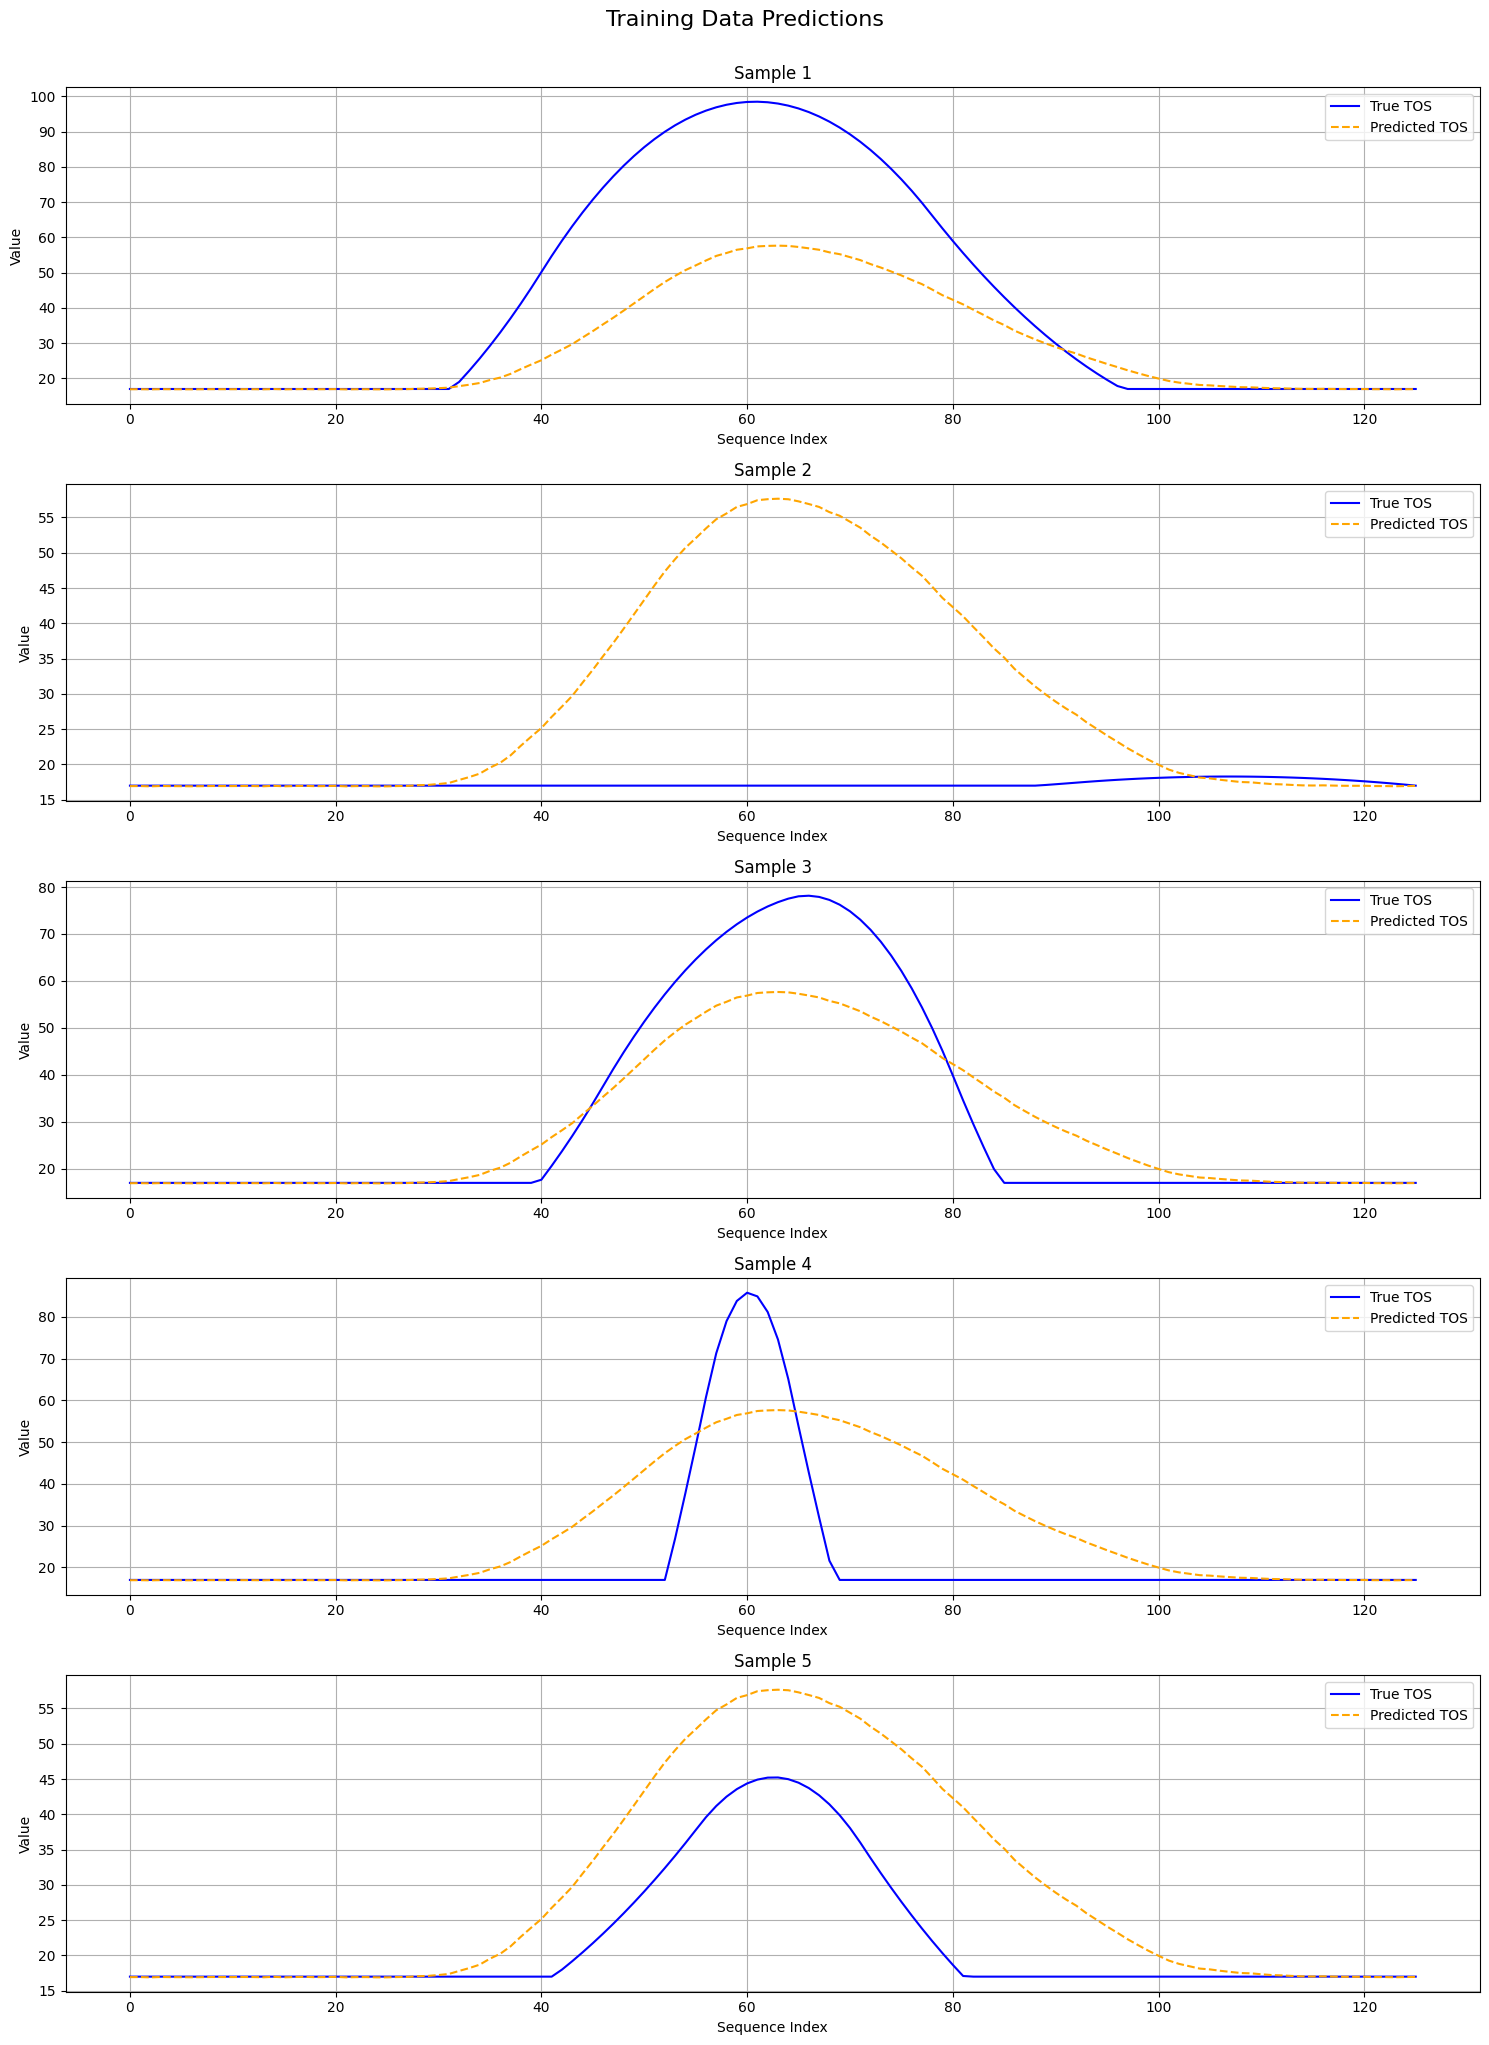

Plotting Testing Data Predictions:


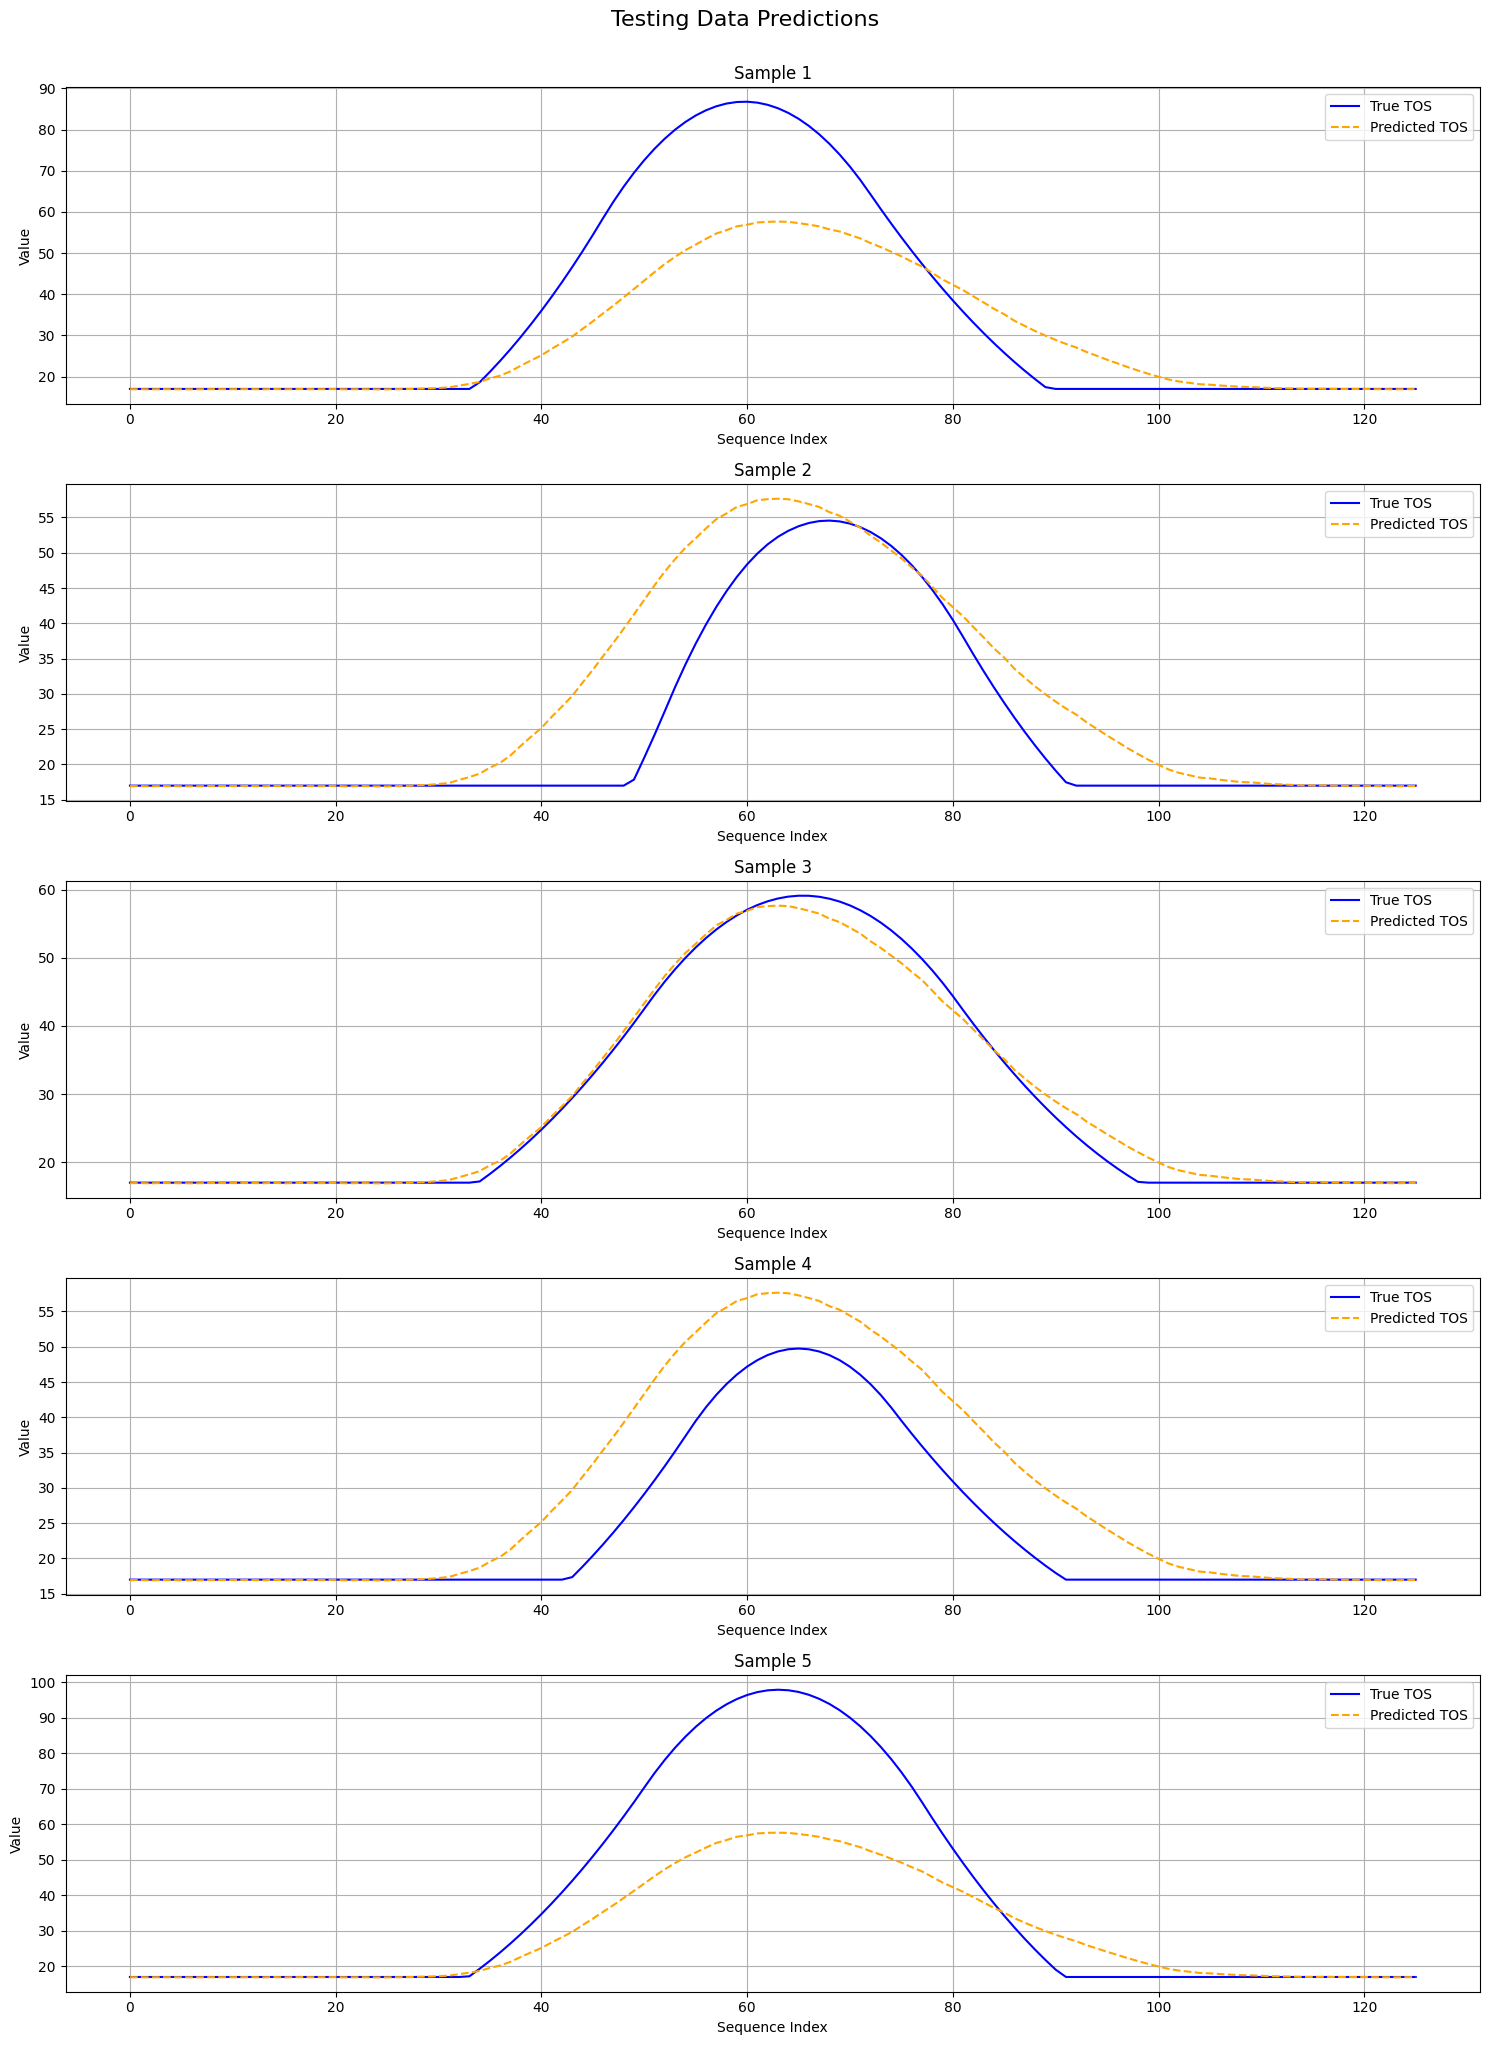

In [16]:
import matplotlib.pyplot as plt
import random

# Function to plot TOS and predictions
def plot_tos_predictions(model, dataloader, device, title="TOS Predictions", num_samples=5):
    """
    Plots true TOS and predicted TOS for a few samples from a dataloader.
    
    Args:
    - model: Trained model.
    - dataloader: DataLoader (train or test).
    - device: Device used for computation.
    - title: Title of the plot.
    - num_samples: Number of samples to plot.
    """
    model.eval()
    true_tos = []
    predicted_tos = []
    
    # Get a few samples
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            predictions = model(inputs)
            
            true_tos.extend(targets.cpu().numpy())
            predicted_tos.extend(predictions.cpu().numpy())
            
            if len(true_tos) >= num_samples:
                break  # Stop after collecting the required number of samples

    # Randomly select num_samples to plot
    indices = random.sample(range(len(true_tos)), num_samples)
    true_tos = [true_tos[i] for i in indices]
    predicted_tos = [predicted_tos[i] for i in indices]
    
    # Plot each sample
    plt.figure(figsize=(15, num_samples * 4))
    for i, (true, pred) in enumerate(zip(true_tos, predicted_tos)):
        plt.subplot(num_samples, 1, i + 1)
        plt.plot(true, label="True TOS", color='blue')
        plt.plot(pred, label="Predicted TOS", color='orange', linestyle='--')
        plt.title(f"Sample {i + 1}")
        plt.xlabel("Sequence Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.suptitle(title, fontsize=16, y=1.02)
    plt.show()

# Plotting training data
print("Plotting Training Data Predictions:")
plot_tos_predictions(model, train_dataloader, device, title="Training Data Predictions", num_samples=5)

# Plotting testing data
print("Plotting Testing Data Predictions:")
plot_tos_predictions(model, test_dataloader, device, title="Testing Data Predictions", num_samples=5)